## LOADING DATA

In [24]:
import pandas as pd
import pyarrow as pa
import pyarrow.compute as pc
import pyarrow.parquet as pq

# Load numeric columns
cols = [
    "tripduration",
    "start_station_id",
    "start_station_latitude",
    "start_station_longitude",
    "end_station_id",
    "end_station_latitude",
    "end_station_longitude",
    "bikeid",
    "birth_year",
    "gender"
]

df = pd.read_parquet("Data/Trips_2018_initial_data.parquet", columns=cols)

pf = pq.ParquetFile("Data/Trips_2018_initial_data.parquet")

chunks = []

for rg in range(pf.num_row_groups):
    print(f"Processing row group {rg+1}/{pf.num_row_groups}...")

    tbl = pf.read_row_group(rg, columns=["starttime", "stoptime", "usertype"])

    # FIX → cast to microsecond timestamp
    tbl = tbl.set_column(
        tbl.schema.get_field_index("starttime"),
        "starttime",
        pc.cast(tbl["starttime"], pa.timestamp("us"), safe=False)
    )
    tbl = tbl.set_column(
        tbl.schema.get_field_index("stoptime"),
        "stoptime",
        pc.cast(tbl["stoptime"], pa.timestamp("us"), safe=False)
    )

    # Convert to pandas
    tmp = tbl.to_pandas()

    # Extract components
    tmp["start_date"]   = tmp["starttime"].dt.date
    tmp["start_hour"]   = tmp["starttime"].dt.hour
    tmp["start_minute"] = tmp["starttime"].dt.minute

    tmp["stop_date"]    = tmp["stoptime"].dt.date
    tmp["stop_hour"]    = tmp["stoptime"].dt.hour
    tmp["stop_minute"]  = tmp["stoptime"].dt.minute

    # Clean up
    tmp = tmp.drop(columns=["starttime", "stoptime"])

    chunks.append(tmp)

extra = pd.concat(chunks, ignore_index=True)
df_full = pd.concat([df, extra], axis=1)

df_full["usertype"] = df_full["usertype"].astype("category")


Processing row group 1/17...
Processing row group 2/17...
Processing row group 2/17...
Processing row group 3/17...
Processing row group 3/17...
Processing row group 4/17...
Processing row group 4/17...
Processing row group 5/17...
Processing row group 5/17...
Processing row group 6/17...
Processing row group 6/17...
Processing row group 7/17...
Processing row group 7/17...
Processing row group 8/17...
Processing row group 8/17...
Processing row group 9/17...
Processing row group 9/17...
Processing row group 10/17...
Processing row group 10/17...
Processing row group 11/17...
Processing row group 11/17...
Processing row group 12/17...
Processing row group 12/17...
Processing row group 13/17...
Processing row group 13/17...
Processing row group 14/17...
Processing row group 14/17...
Processing row group 15/17...
Processing row group 15/17...
Processing row group 16/17...
Processing row group 16/17...
Processing row group 17/17...
Processing row group 17/17...


## PRE PROCESSING DATA

#### CONVERTING DATA TYPES FOR MEMORY EFFICIENCY

In [25]:
df_full["tripduration"] = df_full["tripduration"].astype("int32")
df_full["birth_year"] = df_full["birth_year"].astype("int16")   # fits perfectly
df_full["gender"] = df_full["gender"].astype("int8")
df_full["bikeid"] = df_full["bikeid"].astype("int32")


In [26]:
float_cols = [
    "start_station_id",
    "start_station_latitude",
    "start_station_longitude",
    "end_station_id",
    "end_station_latitude",
    "end_station_longitude"
]

for c in float_cols:
    df_full[c] = df_full[c].astype("float32")


In [27]:
df_full["start_date"] = pd.to_datetime(df_full["start_date"], errors="coerce")
df_full["stop_date"]  = pd.to_datetime(df_full["stop_date"], errors="coerce")


In [28]:
df_full["start_station_id"] = df_full["start_station_id"].astype("Int32")
df_full["end_station_id"]   = df_full["end_station_id"].astype("Int32")


#### GETTING RID OF INVALID STATIONS (OUT OF NEW YORK)

In [29]:
valid_lat = (df_full.start_station_latitude.between(40, 41)) & \
            (df_full.end_station_latitude.between(40, 41))

valid_lon = (df_full.start_station_longitude.between(-75, -73)) & \
            (df_full.end_station_longitude.between(-75, -73))

df_full = df_full[ valid_lat & valid_lon ]


#### GETTING RID OF TOO LONG TRIP TRIPS

In [30]:
df_full = df_full[df_full["tripduration"] <= 86400]


#### GETTING RID OF INVALID BIRTH YEARS

In [31]:
df_full = df_full[df_full["birth_year"].between(1910, 2008)]


#### DROPPING NON EXISITING STATIONS

In [32]:
df_full = df_full.dropna(subset=["start_station_id", "end_station_id"])


#### REFRESHING DATASET

In [33]:
df_full = df_full.reset_index(drop=True)


#### CREATING WEEKDAY, MONTH AND YEAR COLUMNS

In [34]:
df_full["start_weekday"] = df_full["start_date"].dt.weekday.astype("int8")
df_full["start_month"]   = df_full["start_date"].dt.month.astype("int8")
df_full["start_year"]    = df_full["start_date"].dt.year.astype("int16")


In [35]:
df = df_full.copy()

## CLUSTERING

Number of unique start stations: 817


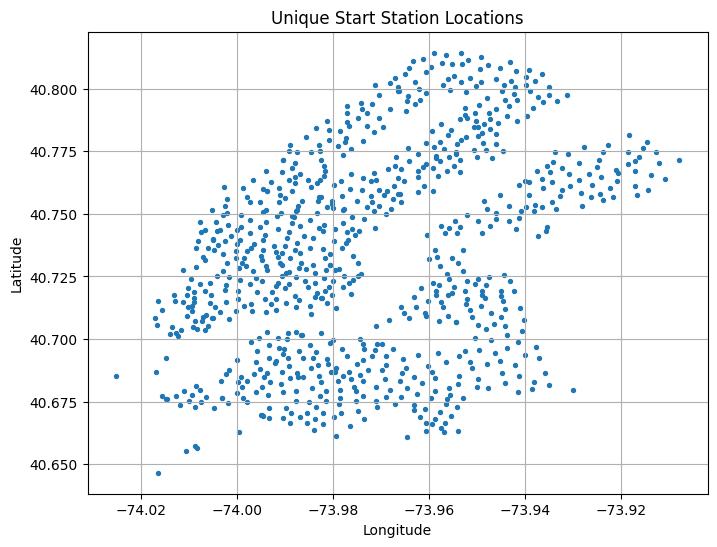

In [36]:
import matplotlib.pyplot as plt

# --- 1. Extract unique start stations ---
unique_stations = (
    df[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
    .dropna()
    .drop_duplicates()
)

# Count
print("Number of unique start stations:", len(unique_stations))

# --- 2. Plot station locations ---
plt.figure(figsize=(8, 6))
plt.scatter(
    unique_stations['start_station_longitude'],
    unique_stations['start_station_latitude'],
    s=8  # small dots for large datasets
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Unique Start Station Locations")
plt.grid(True)
plt.show()

In [37]:
from sklearn.mixture import GaussianMixture
# Unique stations (id → first lat/lon)
unique_stations = (
    df.groupby('start_station_id', observed=True)[['start_station_latitude',
                                                   'start_station_longitude']]
      .first()
      .reset_index()
)

print("Unique start stations:", len(unique_stations))


Unique start stations: 816


k=2, silhouette=0.4787
k=3, silhouette=0.4195
k=4, silhouette=0.3896
k=3, silhouette=0.4195
k=4, silhouette=0.3896
k=5, silhouette=0.3729
k=5, silhouette=0.3729
k=6, silhouette=0.3785
k=7, silhouette=0.4059
k=8, silhouette=0.3835
k=6, silhouette=0.3785
k=7, silhouette=0.4059
k=8, silhouette=0.3835
k=9, silhouette=0.3705
k=10, silhouette=0.3526
k=9, silhouette=0.3705
k=10, silhouette=0.3526
k=11, silhouette=0.3636
k=12, silhouette=0.3674
k=11, silhouette=0.3636
k=12, silhouette=0.3674
k=13, silhouette=0.3489
k=13, silhouette=0.3489
k=14, silhouette=0.3205
k=14, silhouette=0.3205
k=15, silhouette=0.3575
k=15, silhouette=0.3575
k=16, silhouette=0.3924
k=17, silhouette=0.3931
k=18, silhouette=0.3938
k=19, silhouette=0.3824
k=16, silhouette=0.3924
k=17, silhouette=0.3931
k=18, silhouette=0.3938
k=19, silhouette=0.3824
k=20, silhouette=0.3938
k=21, silhouette=0.3806
k=20, silhouette=0.3938
k=21, silhouette=0.3806
k=22, silhouette=0.3778
k=23, silhouette=0.3717
k=24, silhouette=0.3615
k=25, s

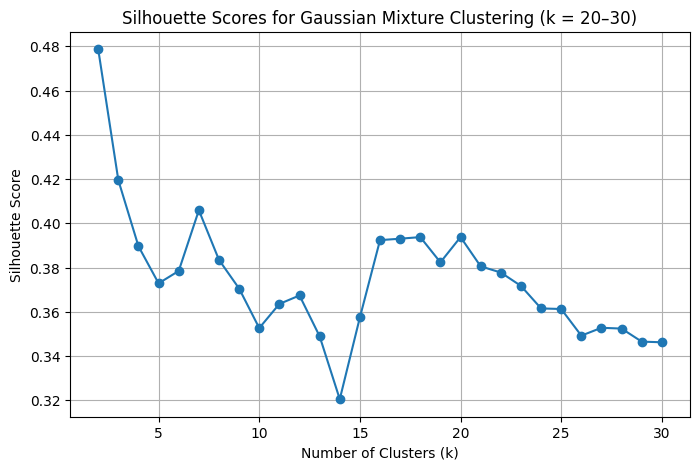

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Your station coordinate matrix
X = unique_stations[['start_station_latitude',
                     'start_station_longitude']].values.astype('float32')

k_values = range(2, 31)
sil_scores = []

for k in k_values:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=42
    )
    gmm.fit(X)
    labels = gmm.predict(X)

    # Silhouette only works if >1 cluster and <number of samples
    score = silhouette_score(X, labels)
    sil_scores.append(score)

    print(f"k={k}, silhouette={score:.4f}")

# Plot silhouette vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_scores, marker='o')

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Gaussian Mixture Clustering (k = 20–30)")
plt.grid(True)
plt.show()


k=2, silhouette=0.4784
k=3, silhouette=0.4253
k=4, silhouette=0.4080
k=5, silhouette=0.3826
k=6, silhouette=0.3848
k=7, silhouette=0.4159
k=8, silhouette=0.3880
k=9, silhouette=0.3811
k=10, silhouette=0.3635
k=11, silhouette=0.3672
k=12, silhouette=0.3673
k=13, silhouette=0.3792
k=14, silhouette=0.3730
k=15, silhouette=0.3950
k=16, silhouette=0.4039
k=11, silhouette=0.3672
k=12, silhouette=0.3673
k=13, silhouette=0.3792
k=14, silhouette=0.3730
k=15, silhouette=0.3950
k=16, silhouette=0.4039
k=17, silhouette=0.4005
k=18, silhouette=0.4057
k=19, silhouette=0.3967
k=20, silhouette=0.4030
k=21, silhouette=0.3880
k=22, silhouette=0.3847
k=23, silhouette=0.3802
k=24, silhouette=0.3740
k=17, silhouette=0.4005
k=18, silhouette=0.4057
k=19, silhouette=0.3967
k=20, silhouette=0.4030
k=21, silhouette=0.3880
k=22, silhouette=0.3847
k=23, silhouette=0.3802
k=24, silhouette=0.3740
k=25, silhouette=0.3736
k=26, silhouette=0.3681
k=27, silhouette=0.3663
k=28, silhouette=0.3612
k=29, silhouette=0.3548


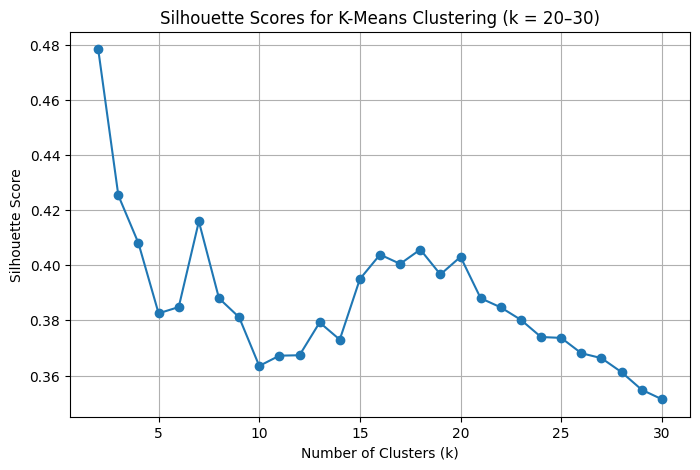

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Coordinate matrix
X = unique_stations[['start_station_latitude',
                     'start_station_longitude']].values.astype('float32')

k_values = range(2, 31)
sil_scores = []

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init='auto',   # fast & stable (or 10 if using older sklearn)
        random_state=42
    )
    
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)

    print(f"k={k}, silhouette={score:.4f}")

# Plot silhouette vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_scores, marker='o')

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for K-Means Clustering (k = 20–30)")
plt.grid(True)
plt.show()


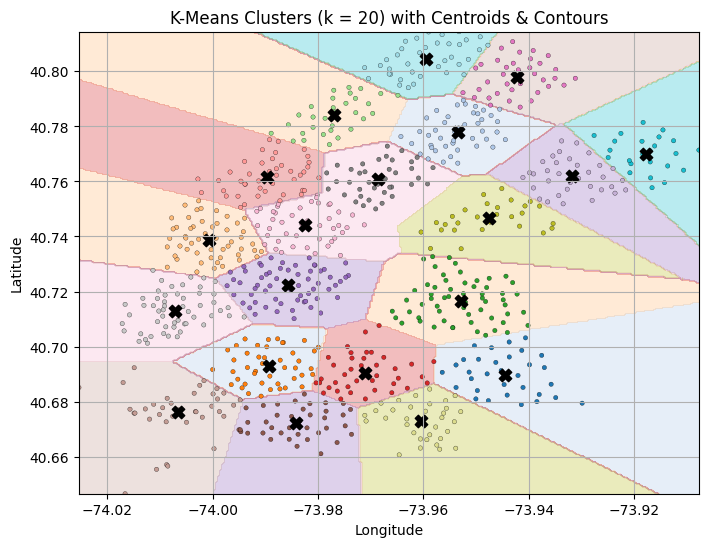

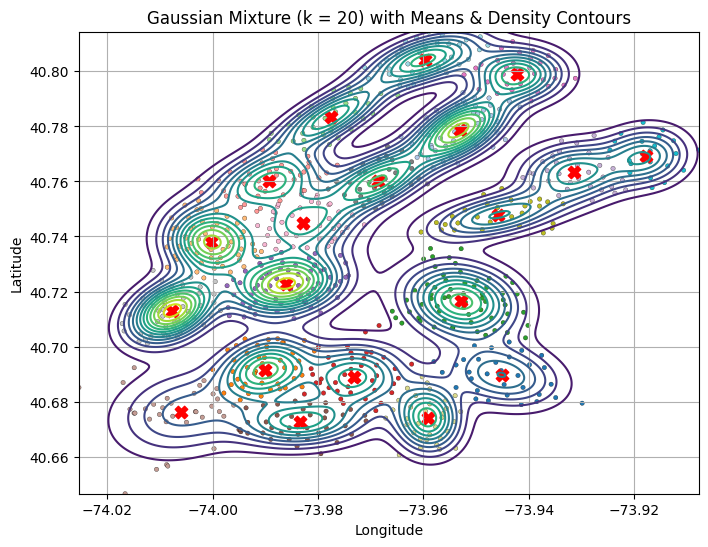

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# ---- Data ------------------------------------------------------
# FIX: Use float64 to avoid "Buffer dtype mismatch" in sklearn/cython
X = unique_stations[['start_station_latitude',
                     'start_station_longitude']].values.astype('float64')

lat = X[:, 0]
lon = X[:, 1]

# ---- Create meshgrid for contours -----------------------------
# Define grid boundaries
lat_min, lat_max = lat.min(), lat.max()
lon_min, lon_max = lon.min(), lon.max()

# Create a fine grid for contouring
xx, yy = np.meshgrid(
    np.linspace(lat_min, lat_max, 300),
    np.linspace(lon_min, lon_max, 300)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]


# ===============================================================
# 1) K-MEANS (k = 20)
# ===============================================================

k = 20
kmeans = KMeans(
    n_clusters=k,
    init='k-means++',
    n_init='auto',
    random_state=42
)
kmeans_labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Predict cluster for each grid point
# X is already float64, grid_points is float64 (from linspace)
grid_labels = kmeans.predict(grid_points)
grid_labels = grid_labels.reshape(xx.shape)

# ---- Plot ----
plt.figure(figsize=(8, 6))

# Contour: cluster regions
plt.contourf(yy, xx, grid_labels, alpha=0.3, cmap='tab20')

# Points
plt.scatter(lon, lat, c=kmeans_labels, s=10, cmap='tab20', edgecolor='k', linewidth=0.2)

# Centroids
plt.scatter(centroids[:, 1], centroids[:, 0], c='black', s=80, marker='X')

plt.title("K-Means Clusters (k = 20) with Centroids & Contours")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


# ===============================================================
# 2) GAUSSIAN MIXTURE (k = 20)
# ===============================================================

gmm = GaussianMixture(
    n_components=k,
    covariance_type='full',
    random_state=42
)
gmm.fit(X)
gmm_labels = gmm.predict(X)

# Means
means = gmm.means_

# Density for contours
log_probs = gmm.score_samples(grid_points)
density = np.exp(log_probs).reshape(xx.shape)

# ---- Plot ----
plt.figure(figsize=(8, 6))

# Density contour
plt.contour(yy, xx, density, levels=15, cmap='viridis')

# Points
plt.scatter(lon, lat, c=gmm_labels, s=10, cmap='tab20', edgecolor='k', linewidth=0.2)

# Means
plt.scatter(means[:, 1], means[:, 0], c='red', s=80, marker='X')

plt.title("Gaussian Mixture (k = 20) with Means & Density Contours")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

## ADD COLUMN WITH CLUSTERS FROM GAUSSIAN MIXTURE(K=20)

In [41]:
from sklearn.mixture import GaussianMixture
import numpy as np

X = unique_stations[['start_station_latitude',
                     'start_station_longitude']].values.astype('float32')

gmm = GaussianMixture(
    n_components=20,
    covariance_type='full',
    random_state=42
)

gmm.fit(X)

# Assign cluster to each station in the unique_stations table
unique_stations['gmm20_cluster'] = gmm.predict(X).astype('int8')


In [42]:
station_to_cluster = dict(
    zip(
        unique_stations['start_station_id'].astype('int64'),
        unique_stations['gmm20_cluster'].astype('int8')
    )
)


In [43]:
df['gmm20_cluster'] = (
    df['start_station_id']
    .astype('int64')
    .map(station_to_cluster)
    .astype('int8')
)


In [44]:
df['end_gmm20_cluster'] = (
    df['end_station_id']
    .astype('float')     # because nullable Int32 may contain NA
    .map(lambda x: station_to_cluster.get(int(x), -1) if not np.isnan(x) else -1)
    .astype('int8')
)

In [45]:
df = df.sort_values(
    by=['start_date', 'start_hour', 'start_minute'],
    ascending=[True, True, True]
).reset_index(drop=True)

In [46]:
df.to_parquet("bike_data_clean.parquet", index=False)
